# Project: Determining buyers age

## <font color='blue'>Step 1. Exploratory analysis of the photographs set</font>

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

!pip install tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
SEED = 12345 

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

     |███████████████████████▎        | 345.1 MB 128.9 MB/s eta 0:00:02

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 475.2 MB 108.6 MB/s eta 0:00:01     |████████████████████████████████| 475.2 MB 7.2 kB/s 
     |████████████████████████████████| 1.7 MB 108.3 MB/s eta 0:00:01
     |████████████████████████████████| 5.5 MB 52.5 MB/s eta 0:00:01
     |████████████████████████████████| 294 kB 77.0 MB/s eta 0:00:01
     |████████████████████████████████| 441 kB 83.1 MB/s eta 0:00:01
     |████████████████████████████████| 18.2 MB 62.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 68.9 MB/s eta 0:00:01
     |████████████████████████████████| 304 kB 101.4 MB/s eta 0:00:01
     |████████████████████████████████| 6.6 MB 81.0 MB/s eta 0:00:01
     |████████████████████████████████| 5.4 MB 75.8 MB/s eta 0:00:01
     |████████████████████████████████| 186 kB 78.1 MB/s eta 0:00:01
  Attempting uninstall: google-auth
    Found existing installation: google-auth 2.11.0
    Uninstalling google-auth-2.11.0:
      Successfully uninstalled google-auth-2.11.0
  

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=SEED)

Found 7591 validated image filenames.


In [4]:
display(labels.shape)
display(labels.head(15))

(7591, 2)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


**The dataset contains 7591 images**

In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


- **The average age is 29**
- **Mostly between 20 and 41**

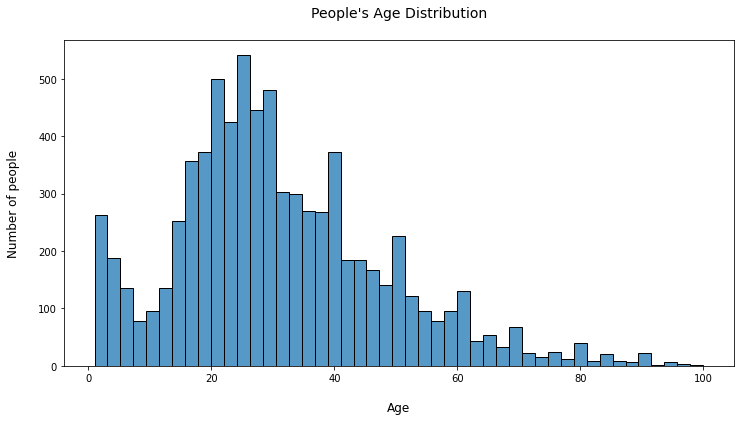

In [6]:
plt.figure(figsize=(12, 6))

plt.title("People's Age Distribution", size = 14, y = 1.05)

sns.histplot(data=labels['real_age'])

plt.xlabel('Age', fontsize=12, labelpad = 18)
plt.ylabel('Number of people', fontsize=12, labelpad=18)

plt.show()

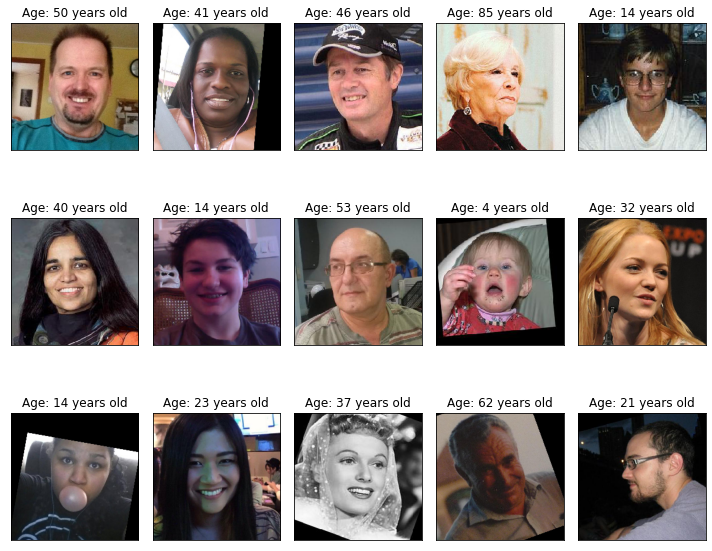

In [7]:
# let's retrieve 15 sample images 

features, target = next(train_datagen_flow)
n, m = 5, 3
fig = plt.figure(figsize=(10,10))
for i in range(n * m):
    fig.add_subplot(m, n, i+1)

    plt.title("Age: {} years old" .format(target[i])) 
    plt.imshow(features[i])

    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

- **The dataset contains photos of different angles, colors, and quality. Some photos are rotated or cropped**.

## <font color='blue'>Step 2. Training a neural network and calculating its quality</font>

The code in this section runs in a separate GPU simulator because neural networks require a lot of computational power, so it is not formatted as a cell with code, but as code in a text cell.

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(dataframe=labels, directory=path + 'final_files/',
        x_col='file_name', y_col='real_age', target_size=(150, 150), batch_size=16, class_mode='raw',
        subset='training', seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(dataframe=labels, directory=path + 'final_files/',
        x_col='file_name', y_col='real_age', target_size=(150, 150), batch_size=16, class_mode='raw',
        subset='validation', seed=12345)

    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet', input_shape=input_shape, include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, validation_data=test_data, batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, verbose=2)

    return model

```

```
Train for 356 steps, validate for 119 steps
Epoch 1/20
2023-11-20 17:16:44.766261: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-11-20 17:16:45.873917: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 65s - loss: 208.5092 - mae: 10.9656 - val_loss: 322.7280 - val_mae: 13.3133
Epoch 2/20
356/356 - 37s - loss: 133.7294 - mae: 8.9162 - val_loss: 260.5924 - val_mae: 12.1716
Epoch 3/20
356/356 - 37s - loss: 112.6268 - mae: 8.0924 - val_loss: 313.2765 - val_mae: 13.6238
Epoch 4/20
356/356 - 36s - loss: 93.3578 - mae: 7.3809 - val_loss: 111.0921 - val_mae: 8.3765
Epoch 5/20
356/356 - 36s - loss: 81.4286 - mae: 6.8551 - val_loss: 132.5894 - val_mae: 8.4413
Epoch 6/20
356/356 - 37s - loss: 68.2093 - mae: 6.3115 - val_loss: 143.1090 - val_mae: 8.8657
Epoch 7/20
356/356 - 36s - loss: 54.2450 - mae: 5.5955 - val_loss: 109.8183 - val_mae: 8.0218
Epoch 8/20
356/356 - 38s - loss: 45.1334 - mae: 5.1740 - val_loss: 99.6627 - val_mae: 7.6234
Epoch 9/20
356/356 - 38s - loss: 40.5109 - mae: 4.8955 - val_loss: 97.3366 - val_mae: 7.3891
Epoch 10/20
356/356 - 38s - loss: 33.6493 - mae: 4.4698 - val_loss: 102.7676 - val_mae: 7.5234
Epoch 11/20
356/356 - 38s - loss: 29.9283 - mae: 4.1959 - val_loss: 100.1301 - val_mae: 7.7537
Epoch 12/20
356/356 - 38s - loss: 28.4213 - mae: 4.1033 - val_loss: 94.6116 - val_mae: 7.2259
Epoch 13/20
356/356 - 39s - loss: 27.0295 - mae: 3.9894 - val_loss: 100.5545 - val_mae: 7.8596
Epoch 14/20
356/356 - 39s - loss: 23.7282 - mae: 3.7494 - val_loss: 96.1629 - val_mae: 7.2299
Epoch 15/20
356/356 - 39s - loss: 22.0872 - mae: 3.6016 - val_loss: 86.4487 - val_mae: 6.8503
Epoch 16/20
356/356 - 39s - loss: 20.8363 - mae: 3.5095 - val_loss: 90.7354 - val_mae: 7.2734
Epoch 17/20
356/356 - 41s - loss: 20.2615 - mae: 3.4698 - val_loss: 107.7735 - val_mae: 7.5374
Epoch 18/20
356/356 - 40s - loss: 18.6313 - mae: 3.3080 - val_loss: 81.6883 - val_mae: 6.7917
Epoch 19/20
356/356 - 40s - loss: 17.1616 - mae: 3.1894 - val_loss: 87.3274 - val_mae: 7.1014
Epoch 20/20
356/356 - 40s - loss: 16.9030 - mae: 3.1753 - val_loss: 81.6394 - val_mae: 6.6884
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 81.6394 - mae: 6.6884
Test MAE: 6.6884

```

- *Best MAE result on the test sample: 6.68; achieved with 20 training epochs*

## <font color='blue'>Step 3. Analysis of the trained model</font>

- A study was conducted to create a neural network that will help determine the appropriate age of a person from photographs.
- As a result, a model was created and trained for which it is possible to obtain a metric value of MAE = 6.68 in the test sample, which is lower than the value required by the condition: 8.
- The Bread-Salt supermarket chain can use the resulting model as a computer system for processing customer photos.
- It is possible to improve the MAE by adding more epochs and trying different values for Adam.